# [1] Load Data

In [2]:
import pandas as pd

In [3]:
# read the data in pandas dataframe
data = pd.read_csv('./dataset/train.csv')

In [8]:
"""Lets have a glimpse of the raw data.
chick dataset/data_description.txt to full feature description 
we have 81 column : 
    79 column is a feature
    1 column Id for each sample 
    1 column for the target feature : SalePrice
"""
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [37]:
"""Get shape of the dataset.
[stage 0 : initial state] We have 1460 sample, 81 feature.
[stage 1 : cleaning feature] We have 1460 sample, 75 feature.
[stage 2 : cleaning sample] We have 1338 sample, 75 feature.
"""
data.shape

(1338, 75)

# [2] Cleaning Data

In [20]:
"""Funtion to extract the features type from 
the dataset in pandas dataframe.

:param df: dataset represented as dataframe. 

Return:
[features] : [feature type dataframe]
"""
def get_feature_types_stats(df):
    features = df.dtypes.rename('feature_type').reset_index().rename(columns={'index':'feature'})
    return features

In [14]:
"""Funtion to get missing data statistics
as pandas dataframe. count and percentage missing data for each feature,
in addition, type of each feature containing missing data.

:function get_feature_types_stats(df): function required to extract feature type.

Return:
[missing_stats] : [statistics of features contaning missing data as dataframe]
"""
def get_feature_stats(df):
    missing_stats = df.isna().sum().rename('missing_count').reset_index().rename(columns={'index':'feature'})
    missing_stats['missing_percentage'] = missing_stats['missing_count']/df.shape[0]
    
    feature_types_df = get_feature_types_stats(df)
    
    missing_stats = missing_stats.merge(feature_types_df,
                         left_on='feature',
                         right_on='feature',
                         how='left')
    return missing_stats

In [40]:
# generate feature statistics 
missing_stats = get_feature_stats(data)

# sorting by missing percentage in ascending way
missing_stats.sort_values('missing_percentage')

,feature,missing_count,missing_percentage,feature_type
0,Id,0,0.0,int64
53,Functional,0,0.0,object
52,TotRmsAbvGrd,0,0.0,int64
51,KitchenQual,0,0.0,object
50,KitchenAbvGr,0,0.0,int64
...,...,...,...,...
22,Exterior2nd,0,0.0,object
21,Exterior1st,0,0.0,object
20,RoofMatl,0,0.0,object
18,YearRemodAdd,0,0.0,int64


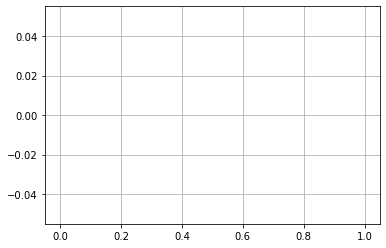

In [39]:
"""Show statistics as histogram.
[x-axis]:[missing_percentage]
[y-axis]:[feature count for each missing_percentage]
"""
missing_stats['missing_percentage'].hist(bins=100)

In [27]:
# I will decide to delete all features with more than 10% 
features_to_delete = missing_stats[missing_stats['missing_percentage'] > 0.1]['feature'].values
features_to_delete

In [31]:
# delete the feature which have missing_percentage more than 10%
data.drop(columns=features_to_delete, inplace=True)

In [ ]:
# delete the samples corresponding to the missing values
for one_feature in missing_stats['feature'].values:
    data = data[ data[one_feature].notna() ]

In [36]:
"""Re compute and skip features with no missing.
[stage 0 : before cleaning] there is 13 feature need to clean
[stage 1 : after cleaning sample] there is no feature need to clean
"""
missing_stats = get_feature_stats(data)
missing_stats = missing_stats[missing_stats['missing_count'] != 0]
missing_stats

,feature,missing_count,missing_percentage,feature_type


# [3] Split Data

# [4] Preprocessing

# [5] Models and Tunning Prameter

# [6] Model Evaluation

# [7] Model Selection

# [8] Pickle